In [5]:
#from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from collections import defaultdict
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import os

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300


In [ ]:
t5_tokenizer = AutoTokenizer.from_pretrained("google-t5/t5-small")
mt5_tokenizer = AutoTokenizer.from_pretrained("google/mt5-small")
gemma_tokenizer = tokenizer = AutoTokenizer.from_pretrained("google/gemma-2b")
#mt5_model = AutoModelForSeq2SeqLM.from_pretrained("google/mt5-small")
mt5_vocab_set = set(mt5_tokenizer.get_vocab())
t5_vocab_set = set(t5_tokenizer.get_vocab())
gemma_vocab_set = set(gemma_tokenizer.get_vocab())
print(len(t5_vocab_set), len(mt5_vocab_set), len(gemma_vocab_set))

/mmfs1/gscratch/ark/knylund/.conda/envs/arkenv/lib/python3.10/site-packages/transformers/convert_slow_tokenizer.py:550: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


32100 250100 256000


In [42]:
# Parse morphynet into dict of lang -> all morphemes:
# Current handling of inflectional morphemes is a bit messed up for deu
# e.g. its' hard to remove babysitt from its segmentation ge-|babysitt|-t because the lemma is babysitten
MORPHYNET_PATH = "/mmfs1/gscratch/ark/knylund/MorphyNet"
lang_to_morphemes = defaultdict(dict)
for lang in tqdm(os.listdir(MORPHYNET_PATH)):
    der_path = f"{MORPHYNET_PATH}/{lang}/{lang}.derivational.v1.tsv"
    inf_path1 = f"{MORPHYNET_PATH}/{lang}/{lang}.inflectional.v1.tsv"
    inf_path2 = f"{MORPHYNET_PATH}/{lang}/{lang}.inflectional.segmentation.v1.tsv"
    if os.path.exists(der_path):
        lang_der_morphynet = pd.read_csv(der_path, sep="\t", names=["source_word", "target_word", "source_POS",
                                                                    "target_POS", "morpheme", "morpheme_type"])
        lang_der_morphemes = set(lang_der_morphynet["morpheme"])
        lang_to_morphemes[lang]["derivational"] = lang_der_morphemes
    inf_path = None
    if os.path.exists(inf_path1):
        inf_path = inf_path1
    elif os.path.exists(inf_path2):
        inf_path = inf_path2
    if inf_path:
        lang_inf_morphynet = pd.read_csv(inf_path, sep="\t", names=["lemma", "inflected_word",
                                                                    "morpheme_features", "morpheme_segmentation"])
        lang_inf_morphemes = set()
        def update_inf_morphemes(row):
            new_morphemes = str(row["morpheme_segmentation"]).split("|")[1:]
            # special segmentation handling since deu has a different format
            #if lang == "deu":
            #    cur_morphemes = set()
            #    for m in new_morphemes:
            #        if "-" in m:
            #            cur_morphemes.add(m.split(" ")[0].replace("-", ""))
            #    new_morphemes = cur_morphemes
            #else:
            new_morphemes = set(m.split(" ")[0].replace("-", "") for m in new_morphemes)
            #new_morphemes.discard(row["lemma"])
            lang_inf_morphemes.update(new_morphemes)
        lang_inf_morphynet.apply(update_inf_morphemes, axis=1)
        lang_to_morphemes[lang]["inflectional"] = lang_inf_morphemes

np.save("./lang_to_morpheme_sets", lang_to_morphemes)

100%|██████████| 17/17 [00:30<00:00,  1.81s/it]


Total number of unique derivational morphemes accross all langs: 6410


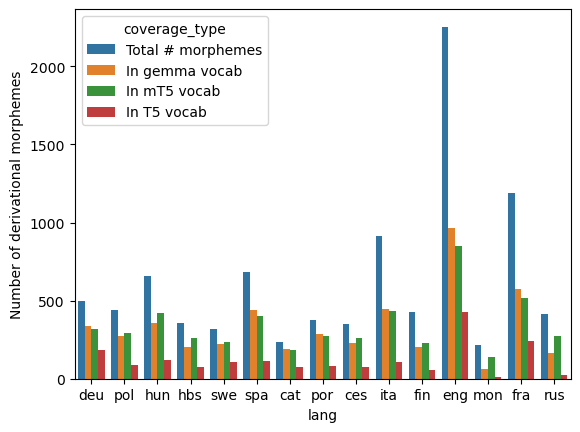

In [37]:
lang_to_morphemes = np.load("./lang_to_morpheme_sets.npy", allow_pickle=True).item()
morpheme_coverage_dicts = []
all_der_morphemes_set = set()
for lang, inf_der_morphemes in lang_to_morphemes.items():
    der_morphemes = inf_der_morphemes["derivational"]
    all_der_morphemes_set.update(der_morphemes)
    morpheme_coverage_dicts.append({"lang": lang, "coverage": len(der_morphemes),
                                    "coverage_type": "Total # morphemes"})
    for vocab_set, vocab_name in zip([gemma_vocab_set, mt5_vocab_set, t5_vocab_set],
                                     ["In gemma vocab", "In mT5 vocab", "In T5 vocab"]):
        morpheme_coverage_dicts.append({"lang": lang, "coverage": len(vocab_set.intersection(der_morphemes)),
                                        "coverage_type": vocab_name})


coverage_pd = pd.DataFrame(morpheme_coverage_dicts)
sns.barplot(data=coverage_pd, x="lang", y="coverage", hue="coverage_type")
plt.ylabel("Number of derivational morphemes")

print("Total number of unique derivational morphemes accross all langs: " + str(len(all_der_morphemes_set)))

In [ ]:
lang_to_pct_of_mt5 = {
    "deu": 3.05,
    "pol": 2.15,
    "hun": 1.48,
    "hbs":
    "swe": 1.61,
    "spa": 3.09,
    "cat": 1.12,
    "por":
    "ces":
    "ita":
    "fin":
    "eng": 5.67,
    "mon":
    "fra":
    "rus":
}

Text(0, 0.5, 'Number of derivational morphemes')

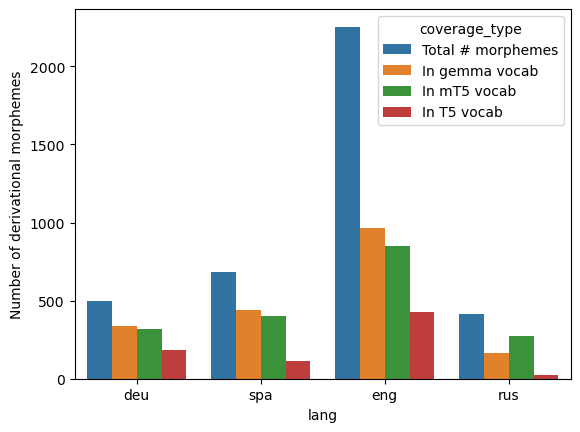

In [ ]:
coverage_pd = pd.DataFrame(morpheme_coverage_dicts)
sns.barplot(data=coverage_pd[coverage_pd["lang"].isin(["eng", "spa", "rus", "deu"])], x="lang", y="coverage", hue="coverage_type")
plt.ylabel("Number of derivational morphemes")

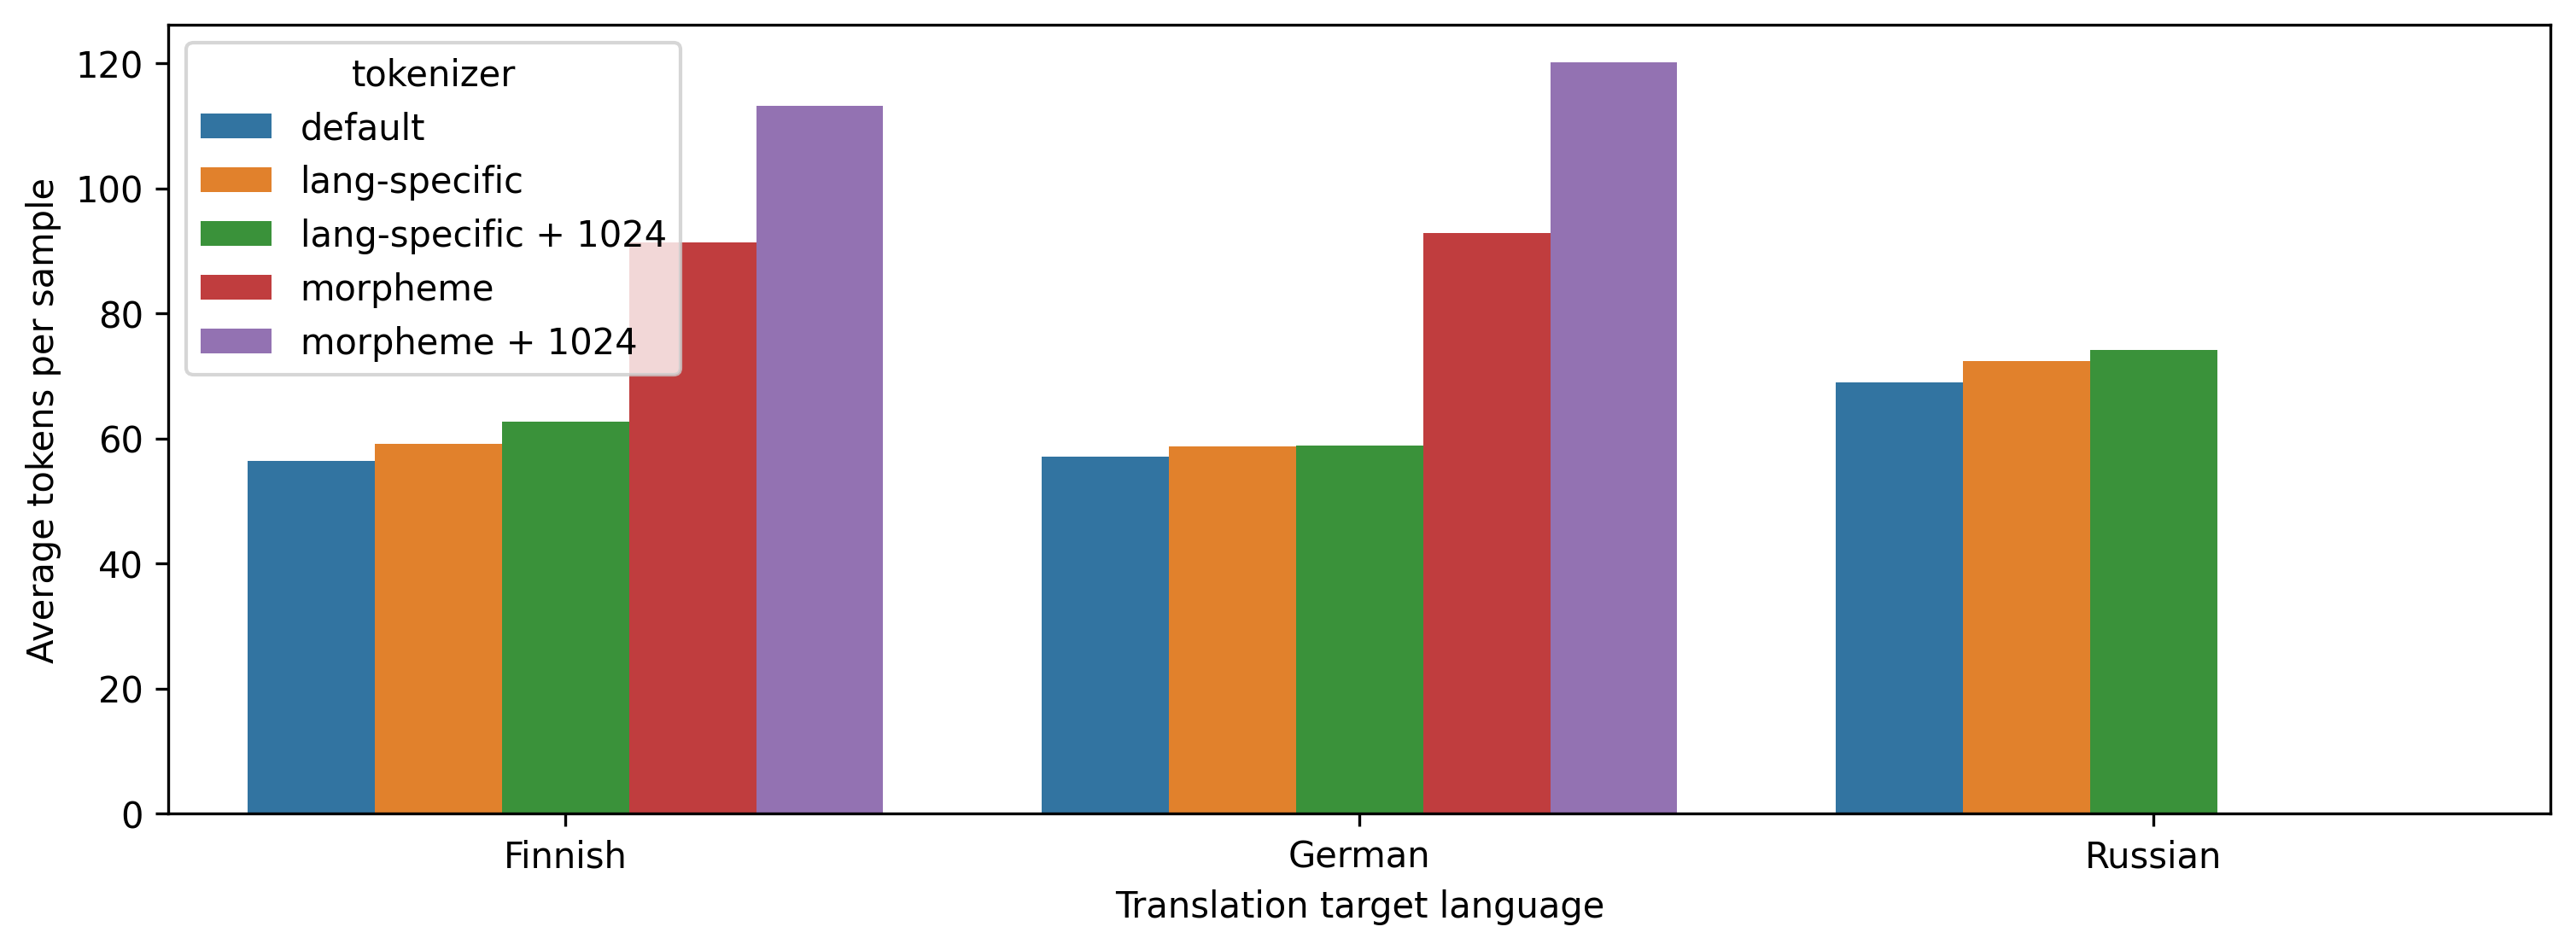

In [8]:
tokenizer_segmentation = pd.DataFrame([
    {"language": "Finnish", "tokenizer": "default", "avg_tokens_per_sample": 56.3993887},
    {"language": "Finnish", "tokenizer": "lang-specific", "avg_tokens_per_sample": 59.16847},
    {"language": "Finnish", "tokenizer": "lang-specific + 1024", "avg_tokens_per_sample": 62.616813},
    {"language": "Finnish", "tokenizer": "morpheme", "avg_tokens_per_sample": 91.3067152},
    {"language": "Finnish", "tokenizer": "morpheme + 1024", "avg_tokens_per_sample": 113.1279291},
    {"language": "German", "tokenizer": "default", "avg_tokens_per_sample": 57.095788},
    {"language": "German", "tokenizer": "lang-specific", "avg_tokens_per_sample": 58.68129},
    {"language": "German", "tokenizer": "lang-specific + 1024", "avg_tokens_per_sample": 58.812963},
    {"language": "German", "tokenizer": "morpheme", "avg_tokens_per_sample": 92.84286},
    {"language": "German", "tokenizer": "morpheme + 1024", "avg_tokens_per_sample": 120.13031},
    {"language": "Russian", "tokenizer": "default", "avg_tokens_per_sample": 68.893131},
    {"language": "Russian", "tokenizer": "lang-specific", "avg_tokens_per_sample": 72.41474},
    {"language": "Russian", "tokenizer": "lang-specific + 1024", "avg_tokens_per_sample": 74.1142560}
])

sns.barplot(data=tokenizer_segmentation, x="language", y="avg_tokens_per_sample", hue="tokenizer")
plt.ylabel("Average tokens per sample")
plt.xlabel("Translation target language")
plt.gcf().set_size_inches(12, 4)